In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [16]:
inf_rate_df = pd.read_csv('./data/inflation rate ph.csv')
int_rate_df = pd.read_csv('./data/monetaryDeicisionProcessed.csv')

snp_500_df = pd.read_csv('./data/S&P 500 Historical Data.csv')
psei_df = pd.read_csv('./data/PSEi Composite Historical Data.csv')

usd_php_df = pd.read_csv('./data/USD_PHP Historical Data.csv')

Some questions we want to try to answer:
1. Inflation rate is bad especially for consumers, we want to know:
    1. does USD/PHP exchange rate affect this number? and how fast?
    2. how strong does inflation rate impract interest rate decisions?
2. Using PSEI to represent philippine economy, 
    1. how does interest rate affect this?
    2. business sometimes use USD, is there correlation with exchange rate
3. How is exchange rate being influenced by snp500 and PSEI?

### Data processing


In [17]:
inf_rate_df['Date'] = pd.to_datetime(inf_rate_df['Year'].astype(str) + '-' + inf_rate_df['Month'].astype(str) + '-01',
            format='%Y-%m-%d')
inf_rate_df.drop(columns=['Year', 'Month'], inplace=True)

In [18]:
int_rate_df['Date'] = pd.to_datetime(int_rate_df['Date'])

In [19]:
snp_500_df['Date'] = pd.to_datetime(snp_500_df['Date'])
snp_500_df['Price'] = snp_500_df['Price'].str.replace(',','').astype(float)
snp_500_df['Change %'] = snp_500_df['Change %'].str.replace('%','').astype(float)
# snp_500_df.drop(columns=['Vol.'], inplace=True)

In [20]:
psei_df['Date'] = pd.to_datetime(psei_df['Date'])
psei_df['Price'] = psei_df['Price'] .str.replace(',','').astype(float)
psei_df['Change %']  = psei_df['Change %'].str.replace('%','').astype(float)

In [21]:
usd_php_df['Date'] = pd.to_datetime(usd_php_df['Date'])
usd_php_df['Change %']  = usd_php_df['Change %'].str.replace('%','').astype(float)

### Feature selection

In [22]:
scaler = MinMaxScaler()

In [23]:
inf_rate_df['normalized_inflation'] = scaler.fit_transform(inf_rate_df[['Inflation Rate YoY']])
int_rate_df['normalized_TRRR'] = scaler.fit_transform(int_rate_df[['TRRR']])
snp_500_df['normalized_price'] = scaler.fit_transform(snp_500_df[['Price']])
psei_df['normalized_price'] = scaler.fit_transform(psei_df[['Price']])
usd_php_df['normalized_price'] = scaler.fit_transform(usd_php_df[['Price']])

In [24]:
temp1 = snp_500_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp1 = temp1.rename(columns={'Price': 'SNP500_Price', 'normalized_price': 'SNP500_Normalized'})

temp2 = psei_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp2 = temp2.rename(columns={'Price': 'PSEI_Price', 'normalized_price': 'PSEI_Normalized'})

temp3 = usd_php_df[['Date','Price', 'normalized_price']].resample('M', on='Date').mean().reset_index()
temp3 = temp3.rename(columns={'Price': 'USD_PHP_Price', 'normalized_price': 'USD_PHP_Normalized'})

merged_df = temp1.merge(temp2, on='Date').merge(temp3, on='Date')

In [25]:
# temp1 = int_rate_df.resample('M', on='Date').mean().reset_index().ffill()
# int_rate_df
temp2 = inf_rate_df.resample('M', on='Date').mean().reset_index()
merged_df = merged_df.merge(temp2[['Date', 'normalized_inflation']], on='Date')
merged_df['Date'] = merged_df['Date'].dt.strftime("%Y-%m")

### Analysis

In [26]:
merged_df.columns

Index(['Date', 'SNP500_Price', 'SNP500_Normalized', 'PSEI_Price',
       'PSEI_Normalized', 'USD_PHP_Price', 'USD_PHP_Normalized',
       'normalized_inflation'],
      dtype='object')

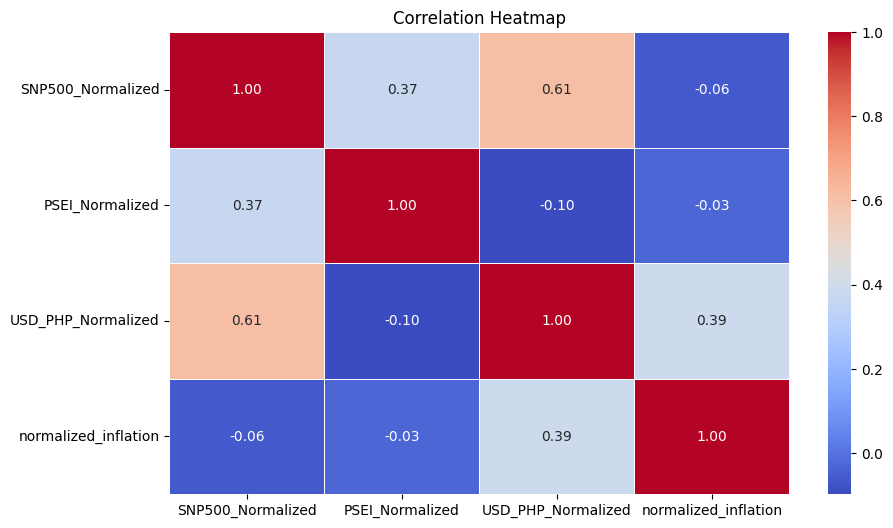

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged_df[['SNP500_Normalized', 'PSEI_Normalized', 'USD_PHP_Normalized', 'normalized_inflation']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Correlation Heatmap")
plt.show()


### Judging by the Image Above (from Highest to Lowest)

**0.61** - S&P 500 | Exchange Rate  
There is a moderate positive correlation between the US economy and the exchange rate. As stock prices increase, the PHP tends to depreciate.

**0.39** - Exchange Rate | Inflation  
A weak correlation, which can mean two things:  
1. When the exchange rate increases, imported goods become more expensive.  
2. Due to inflation, the PHP depreciates faster than the USD.

**0.37** - PSEI | S&P 500  
A weak correlation, meaning the Philippine stock market is somewhat influenced by the US stock market but not strongly.

**-0.10** - PSEI | Exchange Rate  
Although close to 0, this confirms the suspected direction of influence.
